#  Variant 2 - BERT - Tensor flow 2  and High Memory CPU Instance of 14GB RAM required


In [1]:
# software needed - Tensorflow 2
! pip list | grep "tensorflow"   # Check tensorflow==2.0.0, tensorflow-gpu==2.0.0
! pip list | grep "transformers" # Check transformers>=2.0.0

tensorflow                    2.3.0          
tensorflow-addons             0.8.3          
tensorflow-datasets           2.1.0          
tensorflow-estimator          2.3.0          
tensorflow-gcs-config         2.3.0          
tensorflow-hub                0.9.0          
tensorflow-metadata           0.23.0         
tensorflow-privacy            0.2.2          
tensorflow-probability        0.11.0         
transformers                  3.1.0          


In [2]:
# imports and installs
!pip install pandasql
!pip install transformers
import pandasql as ps
import tensorflow as tf
import csv
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense, SpatialDropout1D,Dropout, Activation, Flatten, Embedding, Conv1D, GlobalMaxPooling1D, GlobalAveragePooling1D
from tensorflow.keras.datasets import imdb
import tensorflow as tf
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.layers import Dense, Input, Dropout, LSTM, Activation,SimpleRNN,concatenate,Flatten,MaxPooling1D
from tensorflow.keras.models import Model
from keras.regularizers import l2
from tensorflow.keras import optimizers
from tensorflow import keras


In [3]:
#Dataset load and headers
X_Y_full = pd.read_excel('confusion_excel_800.xlsx', sheet_name='Sheet1')
del X_Y_full['Unnamed: 1']
del X_Y_full['Unnamed: 3']
del X_Y_full['Unnamed: 5']
X_Y_full.columns = ['request','response','confusion']
X_Y_full = X_Y_full[X_Y_full['request'].notnull()]
X_Y_full = X_Y_full[X_Y_full['response'].notnull()]

#Lemmatization
import nltk
nltk.download('wordnet')
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()
def lemmatize_text(text):
    listToStr = ' '.join(map(str, [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]))
    return listToStr
X_Y_full['request'] = X_Y_full['request'].apply(lemmatize_text)
X_Y_full['response'] = X_Y_full['response'].apply(lemmatize_text)

# Stop words Removal
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')
X_Y_full = X_Y_full[X_Y_full['request'].notnull()]
X_Y_full = X_Y_full[X_Y_full['response'].notnull()]
X_Y_full['request'] = X_Y_full['request'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
X_Y_full['response'] = X_Y_full['response'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
X_Y_full['request']  = X_Y_full['request'].str.lower().str.strip()
X_Y_full['response']  = X_Y_full['response'].str.lower().str.strip()
X_Y_full['confusion'] = X_Y_full['confusion'].str.lower().str.strip()


# Data Splitting
train, validate,test = np.split(X_Y_full.sample(frac=1).reset_index(drop=True), [int(.8*len(X_Y_full)), int(0.9*len(X_Y_full))])
x_train_request = (train.request)
x_train_response = (train.response)
y_train = (train.confusion)
x_validate_request = (validate.request)
x_validate_response = (validate.response)
y_validate = (validate.confusion)
x_test_request = (test.request )
x_test_response = (test.response )
y_test = (test.confusion)


#Convert target to 0 and 1 and do numpy transformations to leverage fast parallel processing
y_train_new = ps.sqldf("select case when lower(confusion)='yes' then 1 else 0 end as confusion_new from train")
y_test_new = ps.sqldf("select case when lower(confusion)='yes' then 1 else 0 end as confusion_new from test")
y_validation_new = ps.sqldf("select case when lower(confusion)='yes' then 1 else 0 end as confusion_new from validate")
y_train_new = np.asarray(y_train_new['confusion_new'])
y_test_new = np.asarray(y_test_new['confusion_new'])
y_validation_new = np.asarray(y_validation_new['confusion_new'])
y_full = ps.sqldf("select case when lower(confusion)='yes' then 1 else 0 end as confusion_new from X_Y_full")
act_y = np.asarray(y_full['confusion_new'])

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
import tensorflow as tf
from transformers import BertTokenizer
from transformers import TFBertModel

#Initialising BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = TFBertModel.from_pretrained('bert-base-uncased')

# Encode Train set via BERT
row = 0
list_res = list(x_train_response)
req_res_array = np.empty((0,768), float)
for j in x_train_request:
    #req = encode([j])[0]
    input_ids = tf.constant(tokenizer.encode(j))[None, :]  # Batch size 1
    outputs = model(input_ids)
    req = outputs[1][0]   
    input_ids_1 = tf.constant(tokenizer.encode(list_res[row]))[None, :]  # Batch size 1
    outputs_1 = model(input_ids_1)
    #res = encode([list_res[row]])[0]
    res = outputs_1[1][0]  
    dif = np.asarray((req - res))
    #print(dif)
    distance = np.power(dif,2)
    
    XNormed = distance/np.linalg.norm(distance)
    #print(XNormed)
    #to_append = np. array(distance)
    req_res_array = np.append(req_res_array, [np.asarray(XNormed)],axis=0)
    row = row+1
    
# Encode validation set via BERT    
row = 0
#import Math
list_res = list(x_validate_response)
req_valid_array = np.empty((0,768), float)
for j in x_validate_request:
    #req = encode([j])[0]
    input_ids = tf.constant(tokenizer.encode(j))[None, :]  # Batch size 1
    outputs = model(input_ids)
    req = outputs[1][0]   
    input_ids_1 = tf.constant(tokenizer.encode(list_res[row]))[None, :]  # Batch size 1
    outputs_1 = model(input_ids_1)
    #res = encode([list_res[row]])[0]
    res = outputs_1[1][0]  
    dif = np.asarray((req - res))
    #print(dif)
    distance = np.power(dif,2)
    XNormed = distance/np.linalg.norm(distance)
    #print(XNormed)
    #to_append = np. array(distance)
    req_valid_array = np.append(req_valid_array, [np.asarray(XNormed)],axis=0)
    row = row+1

# Encode Test set via BERT
    
row = 0
#import Math
list_res = list(x_test_response)
req_test_array = np.empty((0,768), float)
for j in x_test_request:
    #req = encode([j])[0]
    input_ids = tf.constant(tokenizer.encode(j))[None, :]  # Batch size 1
    outputs = model(input_ids)
    req = outputs[1][0]   
    input_ids_1 = tf.constant(tokenizer.encode(list_res[row]))[None, :]  # Batch size 1
    outputs_1 = model(input_ids_1)
    #res = encode([list_res[row]])[0]
    res = outputs_1[1][0]  
    dif = np.asarray((req - res))
    #print(dif)
    distance = np.power(dif,2)
    
    XNormed = distance/np.linalg.norm(distance)
    #print(XNormed)
    #to_append = np. array(distance)
    req_test_array = np.append(req_test_array, [np.asarray(XNormed)],axis=0)
    row = row+1

req_res_array_valid = req_valid_array
req_res_array_test = req_test_array 




Some weights of the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


# Modelling Variant 2


In [8]:
model = Sequential()
#model.add(LSTM(200, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(300,input_dim=768,activation='relu'))
#model.add(Dropout(rate=0.3))
model.add(Dense(20,activation='relu',kernel_regularizer=l2(0.05), bias_regularizer=l2(0.01)))
model.add(Dense(10,activation='relu'))
#model.add(Dropout(rate=0.4))
model.add(Dense(1,activation='sigmoid'))
#model.summary()

#Loss Function # tried different values for learning_rate
from tensorflow.keras import optimizers
from tensorflow import keras
AD = optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(optimizer=AD,
              loss='binary_crossentropy',
              metrics=[keras.metrics.Recall(),keras.metrics.Precision(),'accuracy'])

#Training LSTM model
hist = model.fit(req_res_array, y_train_new,
          batch_size=10,
          epochs=60,verbose=1,validation_data=(req_res_array_valid, y_validation_new)
          )

Epoch 1/60
65/65 [==============================] - 1s 8ms/step - loss: 1.6786 - recall: 0.3003 - precision: 0.5200 - accuracy: 0.5382 - val_loss: 1.0663 - val_recall: 0.0256 - val_precision: 0.3333 - val_accuracy: 0.5000
Epoch 2/60
65/65 [==============================] - 0s 3ms/step - loss: 0.8627 - recall: 0.5842 - precision: 0.5446 - accuracy: 0.5725 - val_loss: 0.7464 - val_recall: 0.2821 - val_precision: 0.6471 - val_accuracy: 0.5750
Epoch 3/60
65/65 [==============================] - 0s 3ms/step - loss: 0.7138 - recall: 0.3927 - precision: 0.5459 - accuracy: 0.5585 - val_loss: 0.6946 - val_recall: 0.4615 - val_precision: 0.6429 - val_accuracy: 0.6125
Epoch 4/60
65/65 [==============================] - 0s 3ms/step - loss: 0.6769 - recall: 0.6304 - precision: 0.5932 - accuracy: 0.6209 - val_loss: 0.7006 - val_recall: 0.1538 - val_precision: 0.4615 - val_accuracy: 0.5000
Epoch 5/60
65/65 [==============================] - 0s 4ms/step - loss: 0.6617 - recall: 0.5380 - precision: 0.6

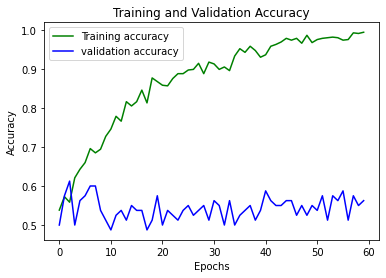

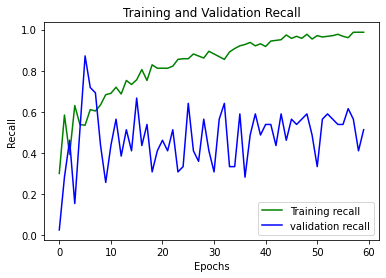

3/3 [==============================] - 0s 4ms/step - loss: 1.7591 - recall: 0.5128 - precision: 0.5556 - accuracy: 0.5625
0.5128205418586731
0.5625
3/3 [==============================] - 0s 3ms/step - loss: 1.3165 - recall: 0.5000 - precision: 0.6562 - accuracy: 0.6049
0.5
0.604938268661499


In [9]:
# Training and validation accuracy and recall growth through epochs

loss_train = hist.history[model.metrics_names[3]]
loss_val = hist.history['val_'+model.metrics_names[3]]
epochs = range(0,60)
plt.plot(epochs, loss_train, 'g', label='Training accuracy')
plt.plot(epochs, loss_val, 'b', label='validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

loss_train = hist.history[model.metrics_names[1]]
loss_val = hist.history['val_'+model.metrics_names[1]]
epochs = range(0,60)
plt.plot(epochs, loss_train, 'g', label='Training recall')
plt.plot(epochs, loss_val, 'b', label='validation recall')
plt.title('Training and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.show()


loss, recall,precision,acc = model.evaluate(req_res_array_valid, y_validation_new)
print(recall)
print(acc)

loss,recall,precision, acc = model.evaluate(req_res_array_test, y_test_new)
print(recall)
print(acc)

# Evaluation of Variant 2 - 10 fold validation

In [5]:
from sklearn.model_selection import KFold
import numpy as np
num_folds = 10

# Define per-fold score containers <-- these are new
acc_per_fold = []
loss_per_fold = []
rec_per_fold = []
per_per_fold = []
acc_per_fold_HS=[]
rec_per_fold_HS=[]
inputs = np.concatenate((req_res_array, req_res_array_valid, req_res_array_test), axis=0)
targets = np.concatenate((y_train_new, y_validation_new,y_test_new), axis=0)
#HS_ = np.concatenate((train_HS_new, validate_HS_new,test_HS_new), axis=0)#

In [6]:
from tensorflow import keras
from tensorflow.keras.layers import Embedding
from tensorflow.keras import layers


kfold = KFold(n_splits=num_folds, shuffle=True)

fold_no = 1
for train, test in kfold.split(inputs, targets):
    model = Sequential()
    #model.add(LSTM(200, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(256,input_dim=768,activation='relu'))
    #model.add(Dropout(rate=0.5))
    model.add(Dense(20,activation='relu',kernel_regularizer=l2(0.05), bias_regularizer=l2(0.01)))
    model.add(Dense(10,activation='relu'))
    #model.add(Dropout(rate=0.4))
    model.add(Dense(1,activation='sigmoid'))
    #model.summary()
    
    AD = optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
    model.compile(optimizer=AD,
                  loss='binary_crossentropy',
                  metrics=[ keras.metrics.Recall(),'accuracy',keras.metrics.Precision()])
    

    
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    
    #Training LSTM model
    history = model.fit(inputs[train], targets[train],
          batch_size=10,
          epochs=60,verbose=1
          )



    #Generate generalization metrics
    scores = model.evaluate(inputs[test], targets[test], verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}% ; {model.metrics_names[2]} of {scores[2]*100}%')
    acc_per_fold.append(scores[2] * 100)
    loss_per_fold.append(scores[0])
    rec_per_fold.append(scores[1])
    per_per_fold.append(scores[3])

    # Increase fold number
    fold_no = fold_no + 1
    
    

    

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%  - Recall: {rec_per_fold[i]}% - Precision: {per_per_fold[i]}%')

print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Recall: {np.mean(rec_per_fold)} (+- {np.std(rec_per_fold)})')
print(f'> Precision: {np.mean(per_per_fold)} (+- {np.std(per_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')







------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/60
73/73 [==============================] - 0s 3ms/step - loss: 1.6174 - recall: 0.0774 - accuracy: 0.5229 - precision: 0.5510
Epoch 2/60
73/73 [==============================] - 0s 3ms/step - loss: 0.8375 - recall: 0.2636 - accuracy: 0.5479 - precision: 0.5714
Epoch 3/60
73/73 [==============================] - 0s 3ms/step - loss: 0.7075 - recall: 0.2607 - accuracy: 0.5659 - precision: 0.6233
Epoch 4/60
73/73 [==============================] - 0s 3ms/step - loss: 0.6876 - recall: 0.4097 - accuracy: 0.6033 - precision: 0.6413
Epoch 5/60
73/73 [==============================] - 0s 3ms/step - loss: 0.6817 - recall: 0.6132 - accuracy: 0.5964 - precision: 0.5784
Epoch 6/60
73/73 [==============================] - 0s 3ms/step - loss: 0.6653 - recall: 0.5817 - accuracy: 0.6602 - precision: 0.6722
Epoch 7/60
73/73 [==============================] - 0s 3ms/step - loss: 0.6541 - recall: 0.54

In [7]:
# List of 10 accuracyand recall scores
acc_per_fold

round_to_tenths = [round(num, 2) for num in acc_per_fold]
print(round_to_tenths)
print(np.mean(round_to_tenths))
print(np.std(round_to_tenths))

rec_per_fold

round_to_tenths_rec = [round(num*100, 2) for num in rec_per_fold]
print(round_to_tenths_rec)
print(np.mean(round_to_tenths_rec))
print(np.std(round_to_tenths_rec))

[69.14, 55.56, 62.5, 60.0, 65.0, 60.0, 68.75, 63.75, 66.25, 57.5]
62.845000000000006
4.353164940592074
[71.43, 61.76, 62.16, 45.0, 70.27, 68.18, 66.67, 55.26, 61.76, 65.12]
62.761
7.455405354506221
